# Telegraph Model
SSA documentation: https://docs.sciml.ai/JumpProcesses/stable/tutorials/discrete_stochastic_example/#ssa_tutorial

In [2]:
using Pkg
Pkg.activate(".")
using Catalyst
using JumpProcesses
using Plots
using Latexify
using NPZ
using DelimitedFiles
using CSV
using DataFrames

  Activating project at `~/stochastic_simulations/julia`
[ Info: Precompiling Catalyst [479239e8-5488-4da2-87a7-35f2df7eef83] (cache misses: wrong dep version loaded (2), incompatible header (2), dep missing source (4))
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (4), incompatible header (2))
[ Info: Precompiling SparseMatrixColoringsColorsExt [42e6ba4b-6785-530d-add2-80af3b5b757b] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970] (cache misses: wrong dep version loaded (6), incompatible header (2))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (6), incompatible header (2))
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c] (cache misses: wrong dep version loaded (4))
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] (cache misses: wrong dep version loaded (2))
[ I

In [3]:
telegraph_model = @reaction_network begin
    sigma_u, G --> G_star
    sigma_b, G_star --> G
    rho, G --> G + M
    d, M --> 0
end

Model ##ReactionSystem#237:
Unknowns (3): see unknowns(##ReactionSystem#237)
  G(t)
  G_star(t)
  M(t)
Parameters (4): see parameters(##ReactionSystem#237)
  sigma_u
  sigma_b
  rho
  d

In [4]:
species(telegraph_model)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 G(t)
 G_star(t)
 M(t)

In [5]:
# print out ODE of the model
latexify(telegraph_model; form = :ode)

L"$\begin{align}
\frac{\mathrm{d} G\left( t \right)}{\mathrm{d}t} &= \mathtt{sigma\_b} \mathtt{G\_star}\left( t \right) - \mathtt{sigma\_u} G\left( t \right) \\
\frac{\mathrm{d} \mathtt{G\_star}\left( t \right)}{\mathrm{d}t} &=  - \mathtt{sigma\_b} \mathtt{G\_star}\left( t \right) + \mathtt{sigma\_u} G\left( t \right) \\
\frac{\mathrm{d} M\left( t \right)}{\mathrm{d}t} &=  - d M\left( t \right) + \mathtt{rho} G\left( t \right)
\end{align}
$"

In [19]:
u0 = [:G => 1, :G_star => 0, :M => 0] # initial conditions, i.e. conc or copy numbers of each specicies at the start of the simulation
tspan = (0.0, 1000.0) # time span
params = [:sigma_u => 0.5, :sigma_b => 0.5, :rho => 100, :d => 1.0] # parameter values

4-element Vector{Pair{Symbol, Float64}}:
 :sigma_u => 0.5
 :sigma_b => 0.5
     :rho => 100.0
       :d => 1.0

  4.351812 seconds (9.14 M allocations: 484.106 MiB, 1.45% gc time, 99.78% compilation time: 99% of which was recompilation)


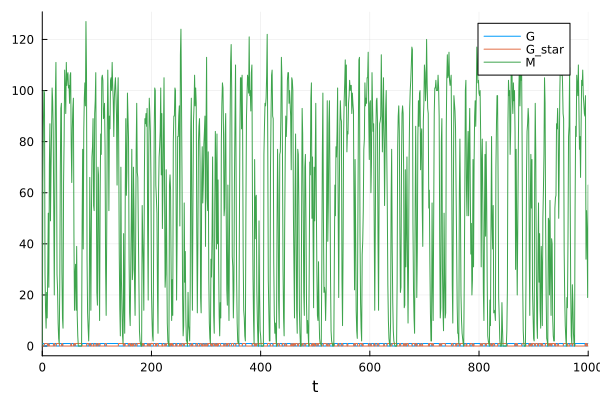

In [33]:
# tracking time taken to run code
@time begin
# running one trajectory for now
telegraph_jinput = JumpInputs(telegraph_model, u0, tspan, params)
telegraph_jprob = JumpProblem(telegraph_jinput; save_positions=(false, false)) # Disable saving at jump positions
telegraph_sol = solve(telegraph_jprob, SSAStepper(), saveat=1.0) # must specify saveat to save at regular intervals
plot(telegraph_sol)
end

In [34]:
size(telegraph_sol)

(3, 1001)

writing this out in csv format

In [ ]:
# persist telegraph_sol in a column-aligned format
state_names = [first(p) for p in u0]
state_matrix = permutedims(Array(telegraph_sol))
sol_df = DataFrame(state_matrix, state_names)
insertcols!(sol_df, 1, :time => telegraph_sol.t)
# sol_column_syms = names(sol_df)
# sol_column_names = String.(sol_column_syms)
# sol_arrays = Dict(string(col) => collect(sol_df[!, col]) for col in sol_column_syms)
# sol_arrays["columns"] = sol_column_names
# save to convert_system
CSV.write("telegraph_sol.csv", sol_df)

"telegraph_sol.csv"

In [47]:
# save to npz
npzwrite("telegraph_sol.npz", Array(telegraph_sol))
sol_npz = npzread("telegraph_sol.npz")
# keys(sol_npz)

3×1001 Matrix{Int64}:
 1   1   1    1   0   0   0  0   0   0  …   1   1   1   0   0   1   0   1   1
 0   0   0    0   1   1   1  1   1   1      0   0   0   1   1   0   1   0   0
 0  64  86  100  99  28  14  7  21  11     95  91  90  98  34  53  44  19  63

## Simulate several trajs

  2.310730 seconds (3.09 M allocations: 148.278 MiB, 4.13% gc time, 49.39% compilation time: 73% of which was recompilation)


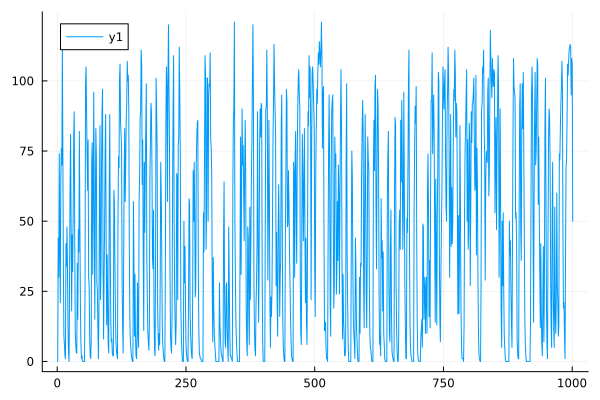

In [37]:
# simulate several trajectories
@time begin
# dprob_telegraph = DiscreteProblem(u0, tspan) # no need for this line? 
traj = 1000
telegraph_jinput = JumpInputs(telegraph_model, u0, tspan, params)
telegraph_jprob = JumpProblem(telegraph_jinput, save_positions=(false, false))
telegraph_eprob = EnsembleProblem(telegraph_jprob)
telegraph_esol = solve(telegraph_eprob, SSAStepper(), saveat=1.0, trajectories=traj)
# plot(telegraph_esol)
plot([w[3] for w in telegraph_esol.u[1000].u])
end

In [38]:
size(telegraph_esol)

(3, 1001, 1000)

writing this out in csv format

In [ ]:
state_names = [first(p) for p in u0]
ensemble_array = Array(telegraph_esol)
permuted = permutedims(ensemble_array, (3, 2, 1))
species_matrix = reshape(permuted, :, length(state_names))
time_points = telegraph_esol.u[1].t
time_col = repeat(time_points, outer=traj)
trajectory_ids = repeat(collect(1:traj), inner=length(time_points))
esol_df = DataFrame(species_matrix, state_names)
insertcols!(esol_df, 1, :time => time_col)
insertcols!(esol_df, 1, :trajectory => trajectory_ids)
# esol_column_syms = names(esol_df)
# esol_column_names = String.(esol_column_syms)
# esol_arrays = Dict(string(col) => collect(esol_df[!, col]) for col in esol_column_syms)
# esol_arrays["columns"] = esol_column_names

# write out results in csv format
CSV.write("telegraph_esol.csv", esol_df)

"telegraph_esol.csv"

In [50]:
npzwrite("telegraph_esol.npz", Array(telegraph_esol))
esol_npz = npzread("telegraph_esol.npz")
# keys(esol_npz)

3×1001×1000 Array{Int64, 3}:
[:, :, 1] =
 1   1    1   1   1   1   0   0   0   0  …  0   1   0   1   1   1   1   1   0
 0   0    0   0   0   0   1   1   1   1     1   0   1   0   0   0   0   0   1
 0  71  108  90  92  88  39  26  46  14     5  49  48  48  61  66  88  58  86

[:, :, 2] =
 1   1   0   0  0  0   1   1   0   1  …   0  0   1   0  0  0   1   0   0   0
 0   0   1   1  1  1   0   0   1   0      1  1   0   1  1  1   0   1   1   1
 0  57  49  17  4  0  10  59  52  92     15  8  16  27  8  2  34  40  77  28

[:, :, 3] =
 1   1   1    1    1    1   0   1   0  …  0  0  0  0  0   0   0  0  0   1   1
 0   0   0    0    0    0   1   0   1     1  1  1  1  1   1   1  1  1   0   0
 0  70  97  106  116  116  94  39  52     4  2  2  2  1  38  21  7  2  64  45

;;; … 

[:, :, 998] =
 1   0   0   0  0  0  0   1   0  0  0  …   1   1   0   0   1   1   0   1   0
 0   1   1   1  1  1  1   0   1  1  1      0   0   1   1   0   0   1   0   1
 0  61  51  20  3  0  0  58  23  8  2     20  73  70  39 

## Finding Steady States

In [28]:
using Catalyst
import HomotopyContinuation

[ Info: Precompiling HomotopyContinuation [f213a82b-91d6-5c5d-acf7-10f1c761b327] (cache misses: wrong dep version loaded (2))
┌ Warning: Module PrettyTables with build ID fafbfcfd-e969-c563-69e5-21a5992792c9 is missing from the cache.
│ This may mean PrettyTables [08abe8d2-0d0c-5749-adfa-8a2ac140af0d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Info: Skipping precompilation due to precompilable error. Importing HomotopyContinuation [f213a82b-91d6-5c5d-acf7-10f1c761b327].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
[ Info: Precompiling ForwardDiffExt [4b8ca102-9d0f-5df8-84ed-253e0f005ba7] (cache misses: wrong dep version loaded (4), incompatible header (2))
┌ Warning: Module ForwardDiff with build ID fafbfcfd-dc9a-270f-ba29-a355efe1cf9e is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilati

In [17]:
methods(hc_steady_states)

# 1 method for generic function "hc_steady_states" from Catalyst:
 [1] hc_steady_states(rs::ReactionSystem, ps; filter_negative, neg_thres, u0, kwargs...)
     @ CatalystHomotopyContinuationExtension ~/.julia/packages/Catalyst/8qDWw/ext/CatalystHomotopyContinuationExtension/homotopy_continuation_extension.jl:38

In [30]:
# Some systems are under-determined, and have an infinite number of possible steady states. These are typically systems containing a conservation law, so 
hc_steady_states(telegraph_model, params; u0)

1-element Vector{Vector{Float64}}:
 [0.5000000000000001, 0.4999999999999998, 50.000000000000014]